In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow import keras
from keras.layers import Input, Embedding, Flatten, Concatenate, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
from keras.models import load_model
from keras.models import Model
from keras.callbacks import EarlyStopping

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# For TensorFlow
print("TensorFlow Version:", tf.__version__)

# For Keras
print("Keras Version:", keras.__version__)


TensorFlow Version: 2.12.0
Keras Version: 2.12.0


In [4]:
# read files into pandas

train_df = pd.read_csv("/kaggle/input/football-events/train.csv")
valid_df = pd.read_csv("/kaggle/input/football-events/valid.csv")
test = pd.read_csv("/kaggle/input/football-events/test.csv")

train_df.possession_team_id.nunique()

60

In [5]:
# remove possession change buffer rows
train_df = train_df[train_df.type != '-']
valid_df = valid_df[valid_df.type != '-']
test = test[test.type != '-']

In [6]:
# reset index
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [7]:
# set integer encoding to start from zero
def reduce_index_values(df):
    df['zone'] = df['zone'] - 1
    df['possession_team_id'] = df['possession_team_id'] - 1
    df['formation'] = df['formation'] - 1

    return df

train_df = reduce_index_values(train_df)
valid_df = reduce_index_values(valid_df)
test = reduce_index_values(test)

In [8]:
valid_df.type.unique()

array(['P', 'D', 'S', 'C'], dtype=object)

In [9]:
print(train_df.type.unique())

type_idx_char = dict((i, c) for i, c in enumerate(train_df.type.unique()))
print(type_idx_char)

type_char_idx = dict((c, i) for i, c in enumerate(train_df.type.unique()))
print(type_char_idx)

# replace categorical actions with integers
train_df['type'].replace(type_char_idx,inplace=True)
valid_df['type'].replace(type_char_idx,inplace=True)
test['type'].replace(type_char_idx,inplace=True)

['P' 'D' 'C' 'S']
{0: 'P', 1: 'D', 2: 'C', 3: 'S'}
{'P': 0, 'D': 1, 'C': 2, 'S': 3}


In [10]:
# create new column for target next action class
def create_target(df):
    df['target_zone'] = df['zone'].shift(-1).ffill(axis = 0).astype(int)
    df['target_type'] = df['type'].shift(-1).fillna(2).astype(int)
    return df

train_df = create_target(train_df)
valid_df = create_target(valid_df)
test = create_target(test)

In [11]:
train_df.head()

,match_id,competition_name,period,eventSec,type,possession,possession_team_id,play_pattern,team_id,player_id,position,duration,under_pressure,shot_outcome,formation,x0,y0,pass_shot,body_part,goals,avg_teammate_distance,avg_opponent_distance,num_teammates,num_opponents,zone,zone_deltay,zone_deltax,zone_dist,zone_dist2g,zone_angle2g,target_zone,target_type
0,3788741,UEFA Euro,1,0,0,2,42,0,43,622,0,1.911,0,0,8,60.0,40.0,0,0,0.0,7.074,12.618,4,6,12,0.0,0.0,0.000,70.000,180.000,6,1
1,3788741,UEFA Euro,1,2,1,2,42,0,43,463,1,1.499,0,0,8,32.5,28.8,1,1,0.0,25.348,31.482,10,10,6,-20.0,-16.0,25.612,91.411,-169.919,6,0
2,3788741,UEFA Euro,1,4,0,2,42,0,43,463,1,2.477,0,0,8,36.2,30.4,1,2,0.0,26.525,22.664,10,8,6,0.0,0.0,0.000,91.411,-169.919,19,1
3,3788741,UEFA Euro,1,6,1,2,42,0,43,438,3,0.102,1,0,8,70.7,75.8,1,1,0.0,34.602,31.491,9,10,19,40.0,48.0,62.482,59.363,147.381,10,0
4,3788741,UEFA Euro,1,12,0,3,45,1,46,420,2,1.930,0,0,2,43.1,0.1,2,1,0.0,28.996,22.139,8,7,10,-20.0,-64.0,67.052,76.968,-155.433,0,1


In [12]:
train = train_df
valid = valid_df

train.possession_team_id.nunique()

60

In [13]:
print(train.shape)
print(test.shape)
print(valid.shape)

(188595, 32)
(25685, 32)
(26915, 32)


In [14]:
train.head()

,match_id,competition_name,period,eventSec,type,possession,possession_team_id,play_pattern,team_id,player_id,position,duration,under_pressure,shot_outcome,formation,x0,y0,pass_shot,body_part,goals,avg_teammate_distance,avg_opponent_distance,num_teammates,num_opponents,zone,zone_deltay,zone_deltax,zone_dist,zone_dist2g,zone_angle2g,target_zone,target_type
0,3788741,UEFA Euro,1,0,0,2,42,0,43,622,0,1.911,0,0,8,60.0,40.0,0,0,0.0,7.074,12.618,4,6,12,0.0,0.0,0.000,70.000,180.000,6,1
1,3788741,UEFA Euro,1,2,1,2,42,0,43,463,1,1.499,0,0,8,32.5,28.8,1,1,0.0,25.348,31.482,10,10,6,-20.0,-16.0,25.612,91.411,-169.919,6,0
2,3788741,UEFA Euro,1,4,0,2,42,0,43,463,1,2.477,0,0,8,36.2,30.4,1,2,0.0,26.525,22.664,10,8,6,0.0,0.0,0.000,91.411,-169.919,19,1
3,3788741,UEFA Euro,1,6,1,2,42,0,43,438,3,0.102,1,0,8,70.7,75.8,1,1,0.0,34.602,31.491,9,10,19,40.0,48.0,62.482,59.363,147.381,10,0
4,3788741,UEFA Euro,1,12,0,3,45,1,46,420,2,1.930,0,0,2,43.1,0.1,2,1,0.0,28.996,22.139,8,7,10,-20.0,-64.0,67.052,76.968,-155.433,0,1


In [15]:
# categorical columns
cat_cols = ['match_id', 'under_pressure', 'zone', 'type', 'possession_team_id', 'position', 'formation']

# float columns
num_cols = ['duration', 'avg_teammate_distance', 'avg_opponent_distance', 'num_teammates', 'num_opponents', 'x0', 'y0',
            'zone_deltay', 'zone_deltax', 'zone_dist', 'zone_dist2g', 'zone_angle2g' ]

In [16]:
input_vars = cat_cols + num_cols 

target_vars = ['target_type']

In [17]:
# filter dataset
train = train[input_vars + target_vars]
valid = valid[input_vars + target_vars]
test = test[input_vars + target_vars]

In [18]:
train.head()

,match_id,under_pressure,zone,type,possession_team_id,position,formation,duration,avg_teammate_distance,avg_opponent_distance,num_teammates,num_opponents,x0,y0,zone_deltay,zone_deltax,zone_dist,zone_dist2g,zone_angle2g,target_type
0,3788741,0,12,0,42,0,8,1.911,7.074,12.618,4,6,60.0,40.0,0.0,0.0,0.000,70.000,180.000,1
1,3788741,0,6,1,42,1,8,1.499,25.348,31.482,10,10,32.5,28.8,-20.0,-16.0,25.612,91.411,-169.919,0
2,3788741,0,6,0,42,1,8,2.477,26.525,22.664,10,8,36.2,30.4,0.0,0.0,0.000,91.411,-169.919,1
3,3788741,1,19,1,42,3,8,0.102,34.602,31.491,9,10,70.7,75.8,40.0,48.0,62.482,59.363,147.381,0
4,3788741,0,10,0,45,2,2,1.930,28.996,22.139,8,7,43.1,0.1,-20.0,-64.0,67.052,76.968,-155.433,1


In [19]:
len(input_vars)

19

In [20]:
# Scale dataset with Min-Max
minmax_scaler = MinMaxScaler()


train[num_cols] = minmax_scaler.fit_transform(train[num_cols])
valid[num_cols] = minmax_scaler.transform(valid[num_cols])
test[num_cols] = minmax_scaler.transform(test[num_cols])

train.head()

/tmp/ipykernel_32/2438470800.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[num_cols] = minmax_scaler.fit_transform(train[num_cols])
/tmp/ipykernel_32/2438470800.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid[num_cols] = minmax_scaler.transform(valid[num_cols])


,match_id,under_pressure,zone,type,possession_team_id,position,formation,duration,avg_teammate_distance,avg_opponent_distance,num_teammates,num_opponents,x0,y0,zone_deltay,zone_deltax,zone_dist,zone_dist2g,zone_angle2g,target_type
0,3788741,0,12,0,42,0,8,0.061396,0.057093,0.110910,0.3,0.545455,0.499583,0.499374,0.5,0.500,0.000000,0.573833,1.000000,1
1,3788741,0,6,1,42,1,8,0.048159,0.204579,0.264546,0.9,0.909091,0.270225,0.359199,0.4,0.375,0.215722,0.778606,0.005132,0
2,3788741,0,6,0,42,1,8,0.079580,0.214079,0.192729,0.9,0.727273,0.301084,0.379224,0.5,0.500,0.000000,0.778606,0.005132,1
3,3788741,1,19,1,42,3,8,0.003277,0.279267,0.264619,0.8,0.909091,0.588824,0.947434,0.7,0.875,0.526266,0.472102,0.907260,0
4,3788741,0,10,0,45,2,2,0.062006,0.234022,0.188453,0.7,0.636364,0.358632,0.000000,0.4,0.000,0.564758,0.640474,0.046318,1


In [21]:
len(valid)

26915

In [22]:
# sequence window function
def create_sequences(df, time_steps, input_cols, target_cols):
    sequences = []
    target = []
    for match in df['match_id'].unique():
        match_data = df[df['match_id'] == match]
        for i in range(len(match_data) - time_steps):
            sequences.append(match_data[input_cols].iloc[i:i+time_steps].values)
            target.append(match_data[target_cols].iloc[i+time_steps -1]) #.values
    return np.array(sequences), np.array(target)

In [55]:
# apply window function
window = 40
X_train, y_train = create_sequences(train, window, input_vars[1:], target_vars)
X_valid, y_valid = create_sequences(valid, window, input_vars[1:], target_vars)
X_test, y_test = create_sequences(test, window, input_vars[1:], target_vars)

In [56]:
# dictionary for categorical unique counts
unique_counts_dict = {}
for col in cat_cols[1:]:
    unique_counts_dict[col] = train_df[col].nunique()

print(unique_counts_dict)

{'under_pressure': 2, 'zone': 30, 'type': 4, 'possession_team_id': 60, 'position': 24, 'formation': 13}


In [57]:
X_train.shape[0]

184115

In [58]:
# create action class weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes = train.type.unique(), y = train.type)
weights = {i: class_weights[i] for i in range(len(class_weights))}

In [77]:
# Define embedding layers for categorical variables
embedding_outputs = []
input_layers = []

# iterate categorical features to create embeddings
for column, unique_count in unique_counts_dict.items():
    input_layer = Input(shape=(window,), name=f"{column}_input")
    embedding = Embedding(unique_count + 1, min(50, unique_count // 2), input_length=window)(input_layer) #embedding process
    lstm_out = LSTM(16, activation='relu')(embedding) # LSTM processing of embeddings

    embedding_outputs.append(lstm_out)
    input_layers.append(input_layer)

num_input = Input(shape=(window, 12), name="numerical_input")
flattened_num = Flatten()(num_input)  # flatten numerical input
input_layers.append(num_input)

# Concatenate embeddings and flattened numerical inputs
merged = Concatenate(axis=-1)(embedding_outputs + [flattened_num])

# Dense layers
x = Dense(16, activation='relu')(merged)
x = Dense(8, activation='relu')(x)

# Output layers
action_output = Dense(4, activation='softmax')(x)

# Create the model with multi-outputs
model = Model(inputs=input_layers, outputs= action_output)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss',patience=10)#,    restore_best_weights=True)


# Compile the model
model.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy',
              metrics= 'sparse_categorical_accuracy')


In [78]:
# extract categorical inputs
X_train_cat_inputs = [X_train[:, :, i] for i in range(6)]
X_valid_cat_inputs = [X_valid[:, :, i] for i in range(6)]
X_test_cat_inputs = [X_test[:, :, i] for i in range(6)]


# extract numerical inputs
X_train_num_input = X_train[:, :, 6:]
X_valid_num_input = X_valid[:, :, 6:]
X_test_num_input = X_test[:, :, 6:]

# merge separate inputs to fit model design inputs
X_train_inputs = X_train_cat_inputs + [X_train_num_input]
X_valid_inputs = X_valid_cat_inputs + [X_valid_num_input]
X_test_inputs = X_test_cat_inputs + [X_test_num_input]



# Fit the model
history = model.fit(
    X_train_inputs, y_train,
    epochs=100,
    batch_size=100,
    validation_data=(X_valid_inputs, y_valid),
    class_weight = weights,
    callbacks=[early_stopping]
    )

Epoch 1/100
1842/1842 [==============================] - 106s 53ms/step - loss: 1.1872 - sparse_categorical_accuracy: 0.4124 - val_loss: 1.1792 - val_sparse_categorical_accuracy: 0.5467
Epoch 2/100
1842/1842 [==============================] - 94s 51ms/step - loss: 0.9887 - sparse_categorical_accuracy: 0.6333 - val_loss: 0.9462 - val_sparse_categorical_accuracy: 0.6373
Epoch 3/100
1842/1842 [==============================] - 95s 51ms/step - loss: 0.9197 - sparse_categorical_accuracy: 0.6446 - val_loss: 1.0616 - val_sparse_categorical_accuracy: 0.5969
Epoch 4/100
1842/1842 [==============================] - 94s 51ms/step - loss: 0.8999 - sparse_categorical_accuracy: 0.6475 - val_loss: 0.9388 - val_sparse_categorical_accuracy: 0.6430
Epoch 5/100
1842/1842 [==============================] - 94s 51ms/step - loss: 0.8886 - sparse_categorical_accuracy: 0.6491 - val_loss: 0.9152 - val_sparse_categorical_accuracy: 0.6460
Epoch 6/100
1842/1842 [==============================] - 96s 52ms/step - l

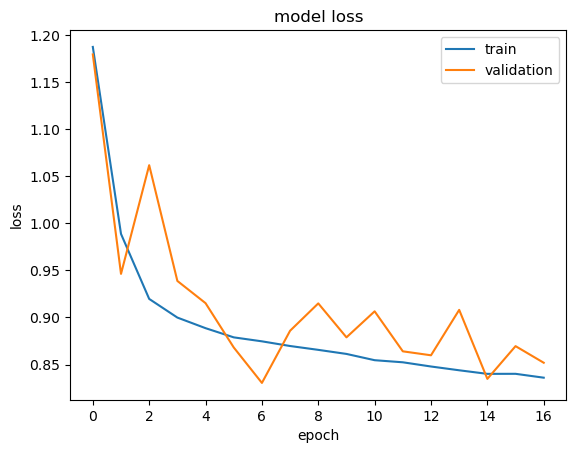

In [79]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [80]:
# model on test set
y_pred = model.predict(X_test_inputs, verbose=0)
predictions = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, predictions, average='weighted')  # Use 'binary' for binary classification, 'weighted' for multi-class
accuracy = accuracy_score(y_test, predictions)

print("F1 Score:", f1)
print("Accuracy:", accuracy)

F1 Score: 0.7393435879612638
Accuracy: 0.7020099502487562


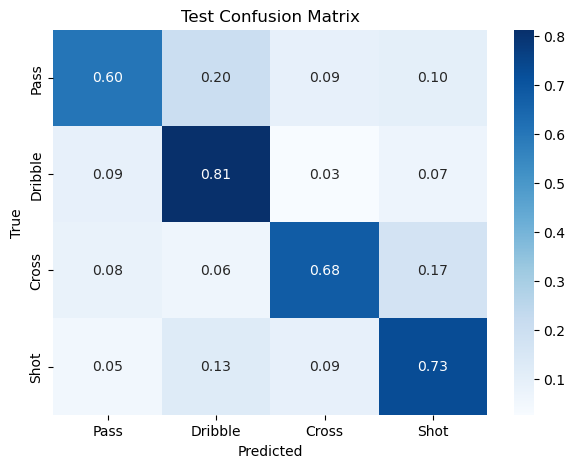

In [81]:
cm = confusion_matrix(y_test, predictions)

labels = ['Pass','Dribble','Cross', 'Shot']
df_confusion = pd.DataFrame(cm, index = labels, columns=labels)
df_confusion['TOTAL'] = df_confusion.sum(axis=1)

cm_percentages = df_confusion.div(df_confusion.TOTAL, axis=0)
cm_percentages.drop(columns='TOTAL', inplace=True)
cm_percentages

plt.figure(figsize=(7,5))
sns.heatmap(cm_percentages, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Test Confusion Matrix')
plt.show()


In [82]:
# model.save('LSTM16_embed_to_Dense')

In [83]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 under_pressure_input (InputLay  [(None, 40)]        0           []                               
 er)                                                                                              
                                                                                                  
 zone_input (InputLayer)        [(None, 40)]         0           []                               
                                                                                                  
 type_input (InputLayer)        [(None, 40)]         0           []                               
                                                                                                  
 possession_team_id_input (Inpu  [(None, 40)]        0           []                           

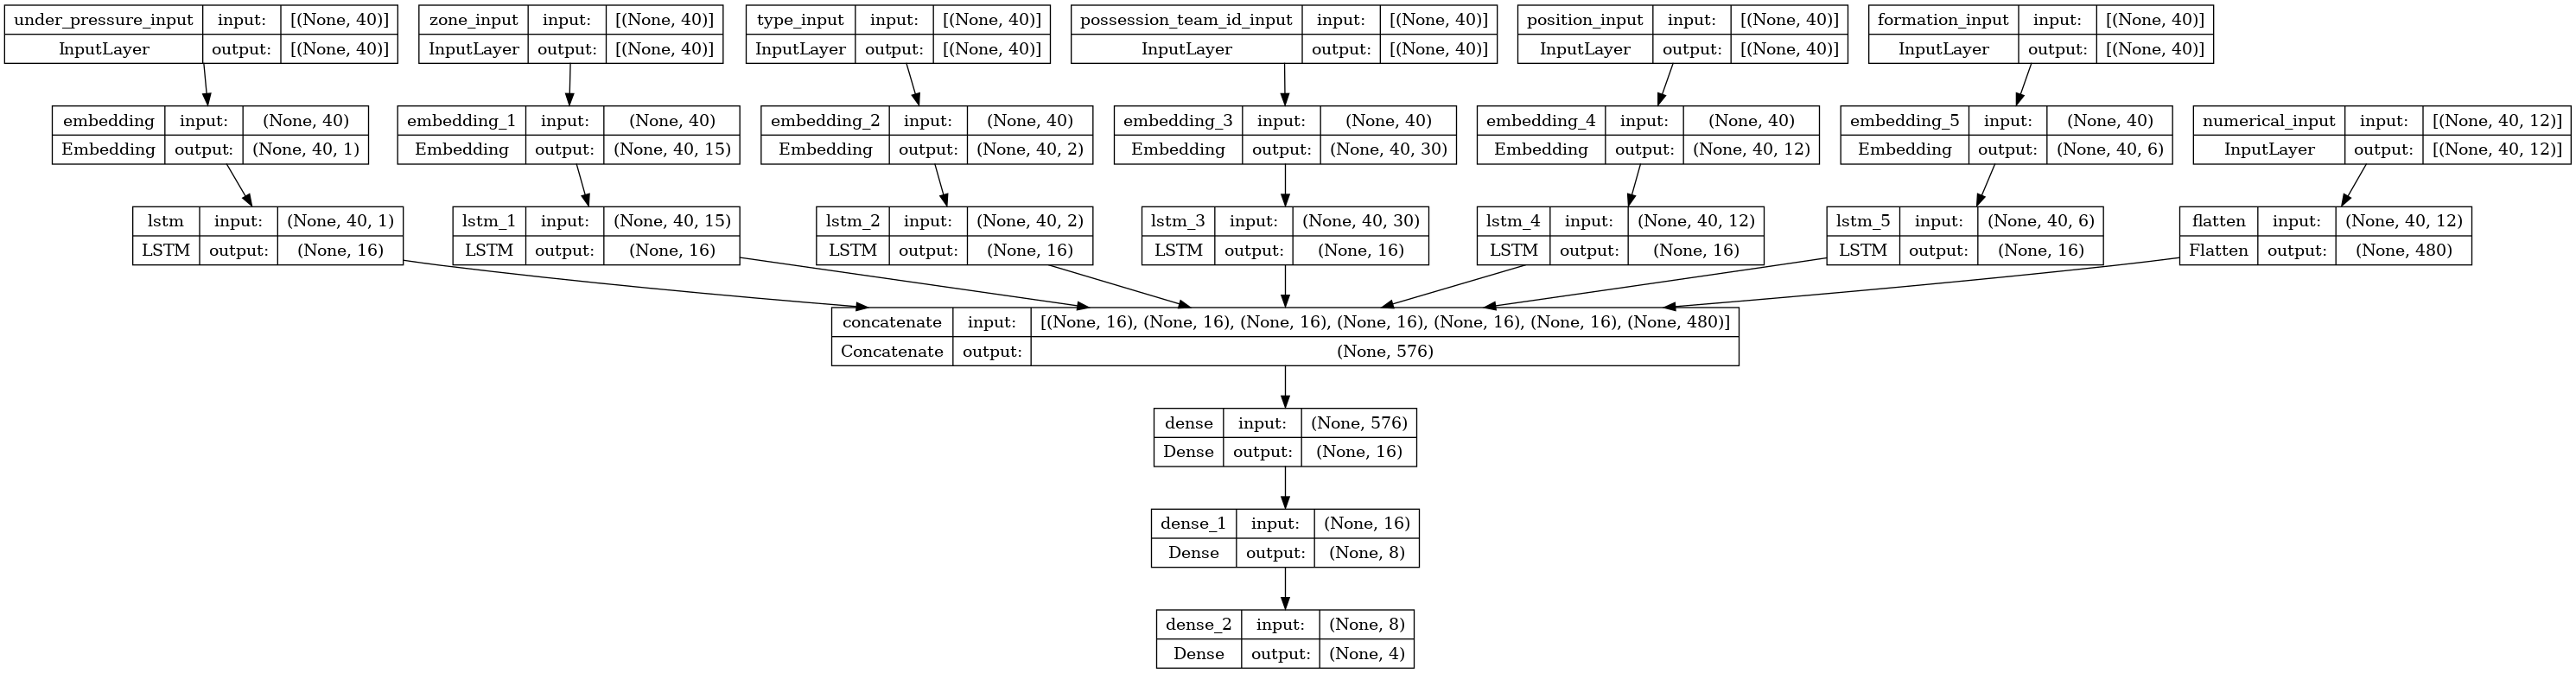

In [84]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [120]:
# select sample team in a sample match
test_match_ids = test.match_id.unique()
selected_match_id = np.random.choice(test_match_ids)

selected_match = test[test.match_id == selected_match_id]
team = selected_match.possession_team_id.value_counts().index[0]
team_match = selected_match[selected_match.possession_team_id == team]

X, y = create_sequences(team_match, 40, input_vars[1:], target_vars)

In [121]:
team_match.shape

(1069, 20)

In [122]:
# load model
loaded = tf.keras.models.load_model("/kaggle/input/test-model/LSTM20_embed_to_Dense/")

# create inputs with selected match and team
cat_inputs = [X[:, :, i] for i in range(6)]
num_input = X[:, :, 6:]

# combine separated inputs
single_test_input = cat_inputs + [num_input]

In [123]:
# evaluate selected match and team
result = loaded.predict(single_test_input, verbose=0)
pred = np.argmax(result, axis=1)

f1 = f1_score(y, pred, average='weighted')  # Use 'binary' for binary classification, 'weighted' for multi-class
accuracy = accuracy_score(y, pred)

print("F1 Score:", f1)
print("Accuracy:", accuracy)

F1 Score: 0.7789967959351379
Accuracy: 0.7414965986394558


In [128]:
# replace integer with string actions
y_act = [type_idx_char[val[0]] for val in y]
pred_act = [type_idx_char[val] for val in pred]

# print the first 30 actions
print(y_act[:30])
print(pred_act[:30])

['D', 'P', 'D', 'C', 'D', 'D', 'P', 'D', 'P', 'D', 'P', 'D', 'D', 'D', 'P', 'D', 'D', 'D', 'P', 'P', 'P', 'D', 'P', 'P', 'D', 'P', 'P', 'D', 'P', 'D']
['D', 'P', 'D', 'C', 'S', 'C', 'P', 'D', 'P', 'D', 'P', 'D', 'P', 'D', 'P', 'D', 'P', 'D', 'P', 'D', 'C', 'D', 'P', 'D', 'D', 'P', 'D', 'D', 'P', 'D']
